In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [45]:
df = pd.read_csv('Btc.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415
...,...,...,...,...,...,...,...
1915,2024-05-28,69392.195312,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
1916,2024-05-29,68296.351562,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
1917,2024-05-30,67576.085938,69500.539062,67118.078125,68364.992188,68364.992188,29509712534
1918,2024-05-31,68362.515625,68999.562500,66633.421875,67491.414062,67491.414062,27387283769


In [46]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [47]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [48]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [49]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [50]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [51]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [52]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 4s 87ms/step - loss: 0.0385 - val_loss: 0.0132
Epoch 2/200
23/23 [==============================] - 2s 83ms/step - loss: 0.0119 - val_loss: 0.0187
Epoch 3/200
23/23 [==============================] - 3s 136ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 4/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 5/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0042 - val_loss: 0.0095
Epoch 6/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 7/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 8/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0028 - val_loss: 0.0081
Epoch 9/200
23/23 [==============================] - 2s 87ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/200
23/23 [==============================] - 3s 128ms/step - loss: 0.0031 - val_loss: 0.00

In [53]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 14ms/step


In [54]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [55]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 2076.362802081015
Testing MAPE: 2.9050597109919845
Testing MAE: 1470.097904704064


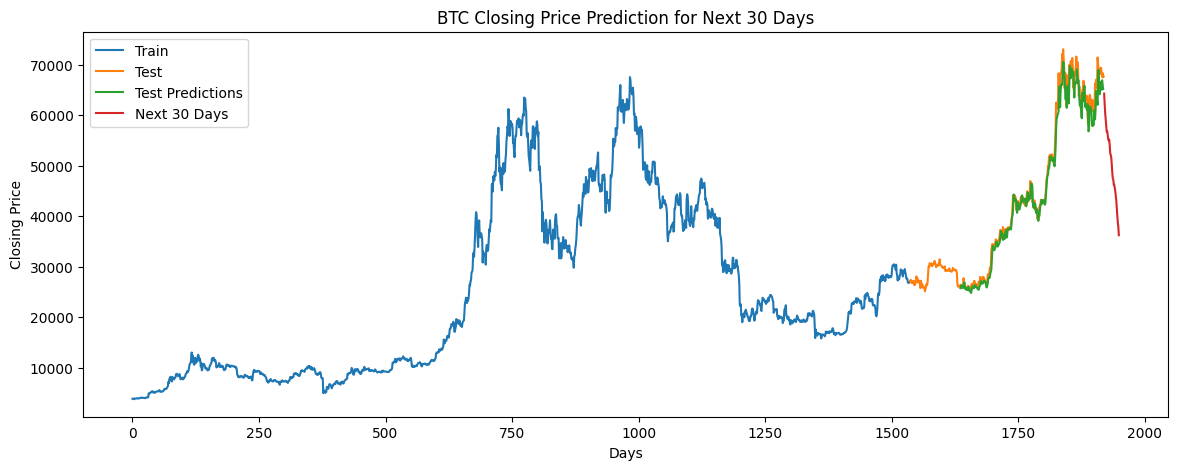

Predicted closing prices for the next 30 days:
[64289.773 62188.594 60489.254 59246.062 58019.71  56791.266 56876.53
 56086.938 55307.55  54992.418 55196.05  54030.273 52444.98  52131.08
 51681.008 50347.98  48695.793 47526.56  47287.543 46246.55  46240.473
 45568.906 44952.69  43978.715 43097.535 41486.44  40058.348 38768.035
 37906.625 36239.926]


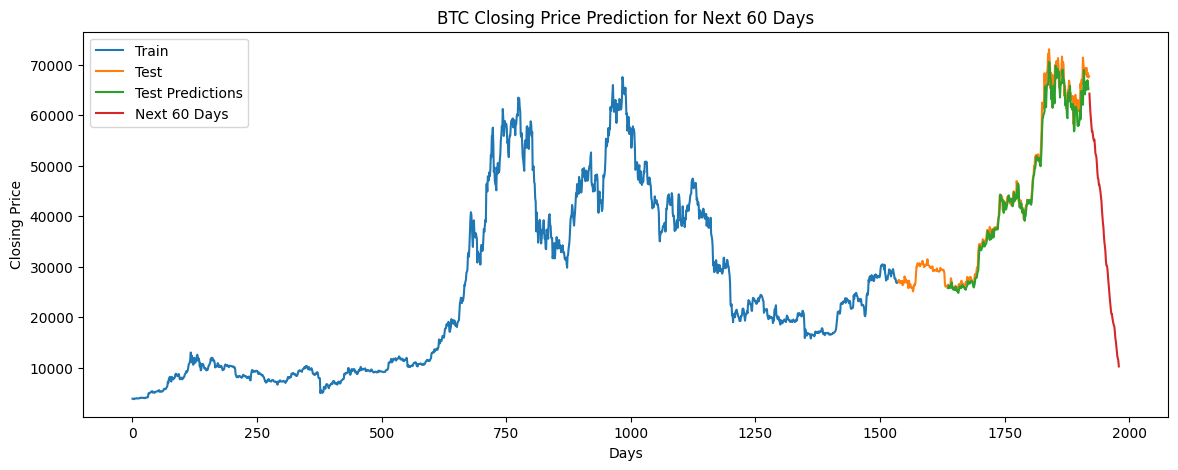

Predicted closing prices for the next 60 days:
[64289.773 62188.594 60489.254 59246.062 58019.71  56791.266 56876.53
 56086.938 55307.55  54992.418 55196.05  54030.273 52444.98  52131.08
 51681.008 50347.98  48695.793 47526.56  47287.543 46246.55  46240.473
 45568.906 44952.69  43978.715 43097.535 41486.44  40058.348 38768.035
 37906.625 36239.926 34914.504 34093.344 33116.332 31283.162 30291.402
 30238.389 29681.535 28443.367 27122.22  26041.729 24780.738 23574.242
 22525.96  21509.252 20661.15  20663.896 19927.053 19287.77  18772.117
 18455.438 18145.777 17125.822 15832.902 15238.516 14270.428 13282.099
 12201.24  11868.313 11357.439 10251.796]


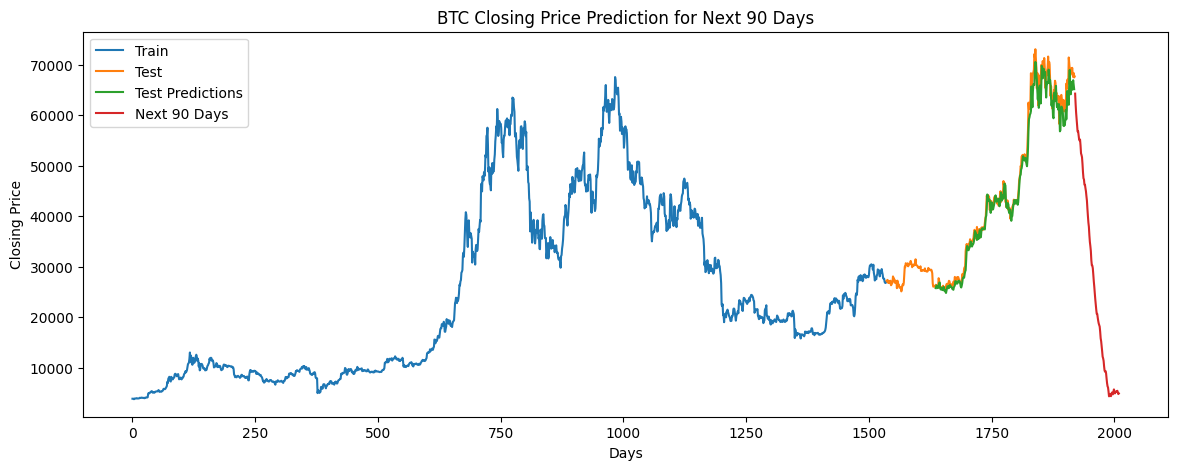

Predicted closing prices for the next 90 days:
[64289.773  62188.594  60489.254  59246.062  58019.71   56791.266
 56876.53   56086.938  55307.55   54992.418  55196.05   54030.273
 52444.98   52131.08   51681.008  50347.98   48695.793  47526.56
 47287.543  46246.55   46240.473  45568.906  44952.69   43978.715
 43097.535  41486.44   40058.348  38768.035  37906.625  36239.926
 34914.504  34093.344  33116.332  31283.162  30291.402  30238.389
 29681.535  28443.367  27122.22   26041.729  24780.738  23574.242
 22525.96   21509.252  20661.15   20663.896  19927.053  19287.77
 18772.117  18455.438  18145.777  17125.822  15832.902  15238.516
 14270.428  13282.099  12201.24   11868.313  11357.439  10251.796
  9418.764   9227.634   9333.476   8909.686   7894.8364  6956.115
  6331.149   6088.8267  5297.64    4332.8804  4506.938   4779.9004
  4624.662   4366.9443  4811.7397  5085.8423  4961.0586  4730.7754
  5236.9307  5708.894   5303.1343  4911.645   5205.773   5244.3047
  5298.2695  5276.2544  5429

In [56]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [57]:
df = pd.read_csv('Btc.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415
...,...,...,...,...,...,...,...
1915,2024-05-28,69392.195312,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
1916,2024-05-29,68296.351562,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
1917,2024-05-30,67576.085938,69500.539062,67118.078125,68364.992188,68364.992188,29509712534
1918,2024-05-31,68362.515625,68999.562500,66633.421875,67491.414062,67491.414062,27387283769


In [58]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [59]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [60]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [61]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [62]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [63]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [64]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 5s 99ms/step - loss: 0.0422 - val_loss: 0.0170
Epoch 2/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0145 - val_loss: 0.0089
Epoch 3/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 4/200
20/20 [==============================] - 2s 83ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 5/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 6/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 7/200
20/20 [==============================] - 2s 112ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 8/200
20/20 [==============================] - 2s 106ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 9/200
20/20 [==============================] - 1s 75ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 10/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0031 - val_loss: 0.00

In [65]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 14ms/step


In [66]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [67]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 1717.6699796016628
Testing MAPE: 2.4227281896320787
Testing MAE: 1083.6575041118424


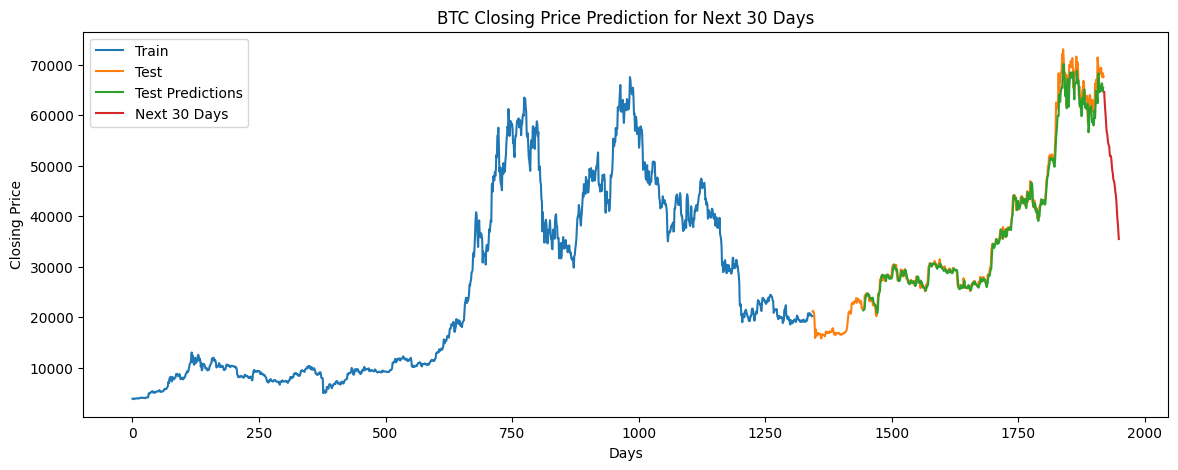

Predicted closing prices for the next 30 days:
[64626.684 62863.754 61200.58  59816.832 58066.395 56690.78  56362.367
 55307.47  54462.527 54095.332 53790.03  52465.34  51852.094 51929.65
 51525.43  50238.066 49111.56  48585.355 47455.29  47011.8   46737.46
 45987.215 44894.598 44275.28  43152.906 41400.95  39720.633 38577.64
 37047.52  35484.785]


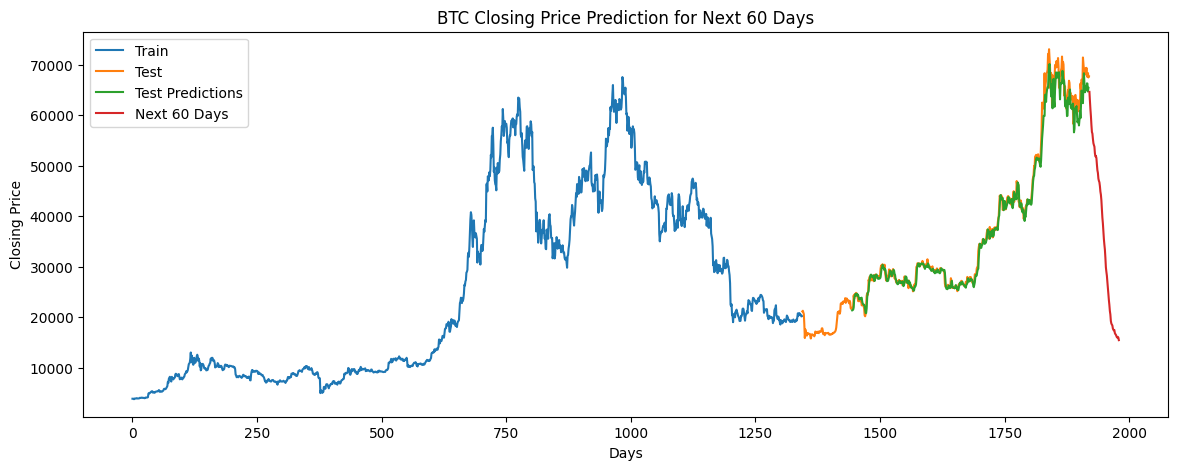

Predicted closing prices for the next 60 days:
[64626.684 62863.754 61200.58  59816.832 58066.395 56690.78  56362.367
 55307.47  54462.527 54095.332 53790.03  52465.34  51852.094 51929.65
 51525.43  50238.066 49111.56  48585.355 47455.29  47011.8   46737.46
 45987.215 44894.598 44275.28  43152.906 41400.95  39720.633 38577.64
 37047.52  35484.785 34374.86  33417.887 31828.371 29893.613 29013.096
 28242.055 27029.65  25821.326 24655.295 23420.68  22445.633 21240.371
 20552.354 19251.584 18746.857 18546.03  18383.867 17783.566 17523.77
 17405.654 17473.559 16876.34  16661.787 16544.926 16293.636 16057.491
 15953.598 16107.613 15955.027 15461.91 ]


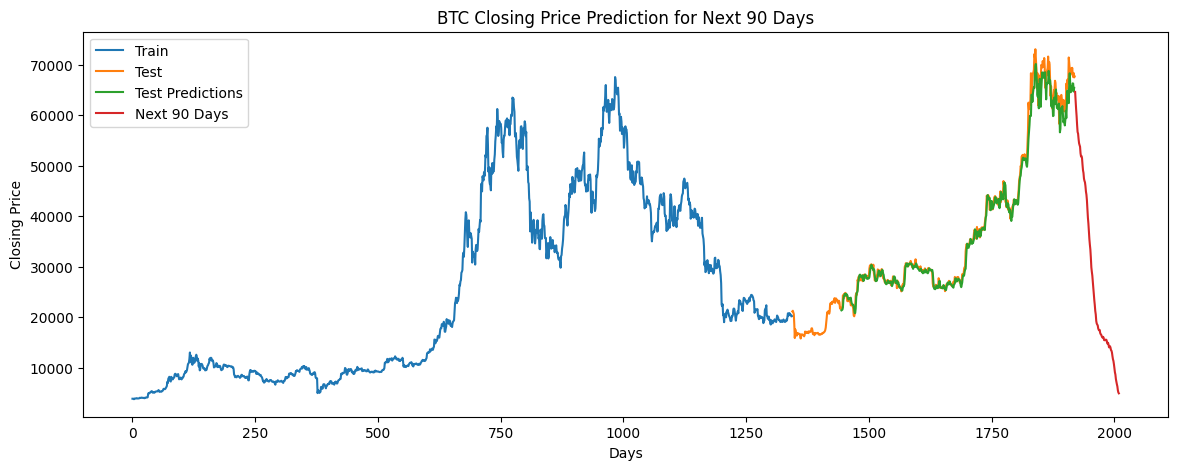

Predicted closing prices for the next 90 days:
[64626.684  62863.754  61200.58   59816.832  58066.395  56690.78
 56362.367  55307.47   54462.527  54095.332  53790.03   52465.34
 51852.094  51929.65   51525.43   50238.066  49111.56   48585.355
 47455.29   47011.8    46737.46   45987.215  44894.598  44275.28
 43152.906  41400.95   39720.633  38577.64   37047.52   35484.785
 34374.86   33417.887  31828.371  29893.613  29013.096  28242.055
 27029.65   25821.326  24655.295  23420.68   22445.633  21240.371
 20552.354  19251.584  18746.857  18546.03   18383.867  17783.566
 17523.77   17405.654  17473.559  16876.34   16661.787  16544.926
 16293.636  16057.491  15953.598  16107.613  15955.027  15461.91
 15457.698  15444.948  15553.882  15561.205  15461.501  15008.211
 14744.643  14939.857  14589.685  14029.875  14076.897  14258.145
 13985.244  13494.125  13370.911  13004.356  12295.596  11689.767
 11340.263  10693.275   9915.5625  9105.556   8649.667   7758.3574
  7230.8755  6729.1934  6307.018

In [68]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [69]:
df = pd.read_csv('Btc.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-01,3853.757080,3907.795410,3851.692383,3859.583740,3859.583740,7661247975
1,2019-03-02,3855.318115,3874.607422,3832.127930,3864.415039,3864.415039,7578786076
2,2019-03-03,3862.266113,3875.483643,3836.905762,3847.175781,3847.175781,7253558152
3,2019-03-04,3845.091553,3867.381836,3733.749756,3761.557129,3761.557129,9029175788
4,2019-03-05,3759.832520,3903.916748,3745.183105,3896.375000,3896.375000,10174126415
...,...,...,...,...,...,...,...
1915,2024-05-28,69392.195312,69514.640625,67227.156250,68296.218750,68296.218750,32722265965
1916,2024-05-29,68296.351562,68852.460938,67101.492188,67578.093750,67578.093750,26707072906
1917,2024-05-30,67576.085938,69500.539062,67118.078125,68364.992188,68364.992188,29509712534
1918,2024-05-31,68362.515625,68999.562500,66633.421875,67491.414062,67491.414062,27387283769


In [70]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [71]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [72]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [73]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [74]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [75]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [76]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 4s 101ms/step - loss: 0.0590 - val_loss: 0.0319
Epoch 2/200
17/17 [==============================] - 2s 120ms/step - loss: 0.0155 - val_loss: 0.0102
Epoch 3/200
17/17 [==============================] - 2s 125ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 4/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0083 - val_loss: 0.0066
Epoch 5/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 6/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0037 - val_loss: 0.0075
Epoch 7/200
17/17 [==============================] - 1s 85ms/step - loss: 0.0033 - val_loss: 0.0084
Epoch 8/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0029 - val_loss: 0.0100
Epoch 9/200
17/17 [==============================] - 1s 81ms/step - loss: 0.0027 - val_loss: 0.0107
Epoch 10/200
17/17 [==============================] - 2s 106ms/step - loss: 0.0026 - val_loss: 0.

In [77]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 14ms/step


In [78]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [79]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 3393.5603244819586
Testing MAPE: 11.445519539400992
Testing MAE: 3126.383313226199


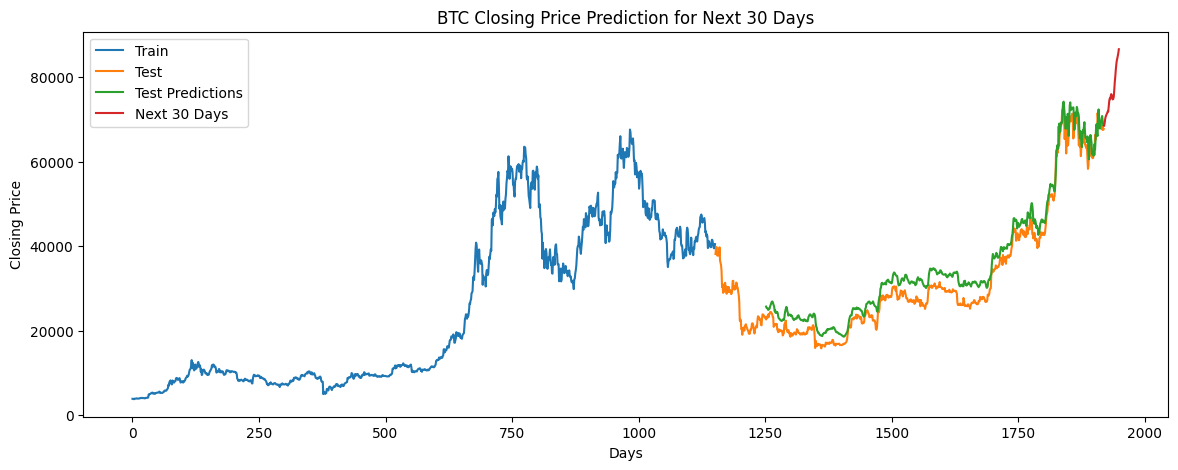

Predicted closing prices for the next 30 days:
[68488.03  69140.48  70052.57  70594.67  70929.57  71204.37  71475.516
 71800.805 71815.66  72987.69  74280.81  74909.914 74752.18  75442.195
 75950.47  75620.914 75155.04  74697.21  74809.22  75348.2   77000.875
 78813.58  80124.08  81696.5   82979.49  83908.73  84437.1   85028.086
 85694.04  86569.94 ]


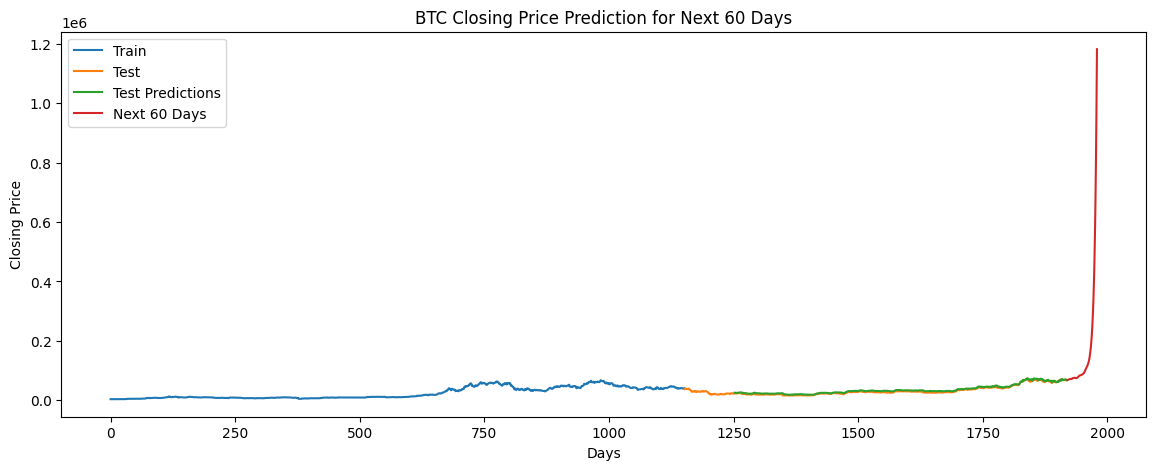

Predicted closing prices for the next 60 days:
[  68488.03    69140.48    70052.57    70594.67    70929.57    71204.37
   71475.516   71800.805   71815.66    72987.69    74280.81    74909.914
   74752.18    75442.195   75950.47    75620.914   75155.04    74697.21
   74809.22    75348.2     77000.875   78813.58    80124.08    81696.5
   82979.49    83908.73    84437.1     85028.086   85694.04    86569.94
   87628.32    89190.24    90771.12    92490.17    95059.82    98582.84
  102709.46   106774.89   110300.59   113641.95   117513.266  121978.98
  127411.83   134037.1    142681.2    153971.7    167404.39   183779.38
  203920.89   228970.02   259922.75   297072.1    343210.84   400720.12
  472162.84   560629.4    670208.     806393.56   974528.56  1181478.6  ]


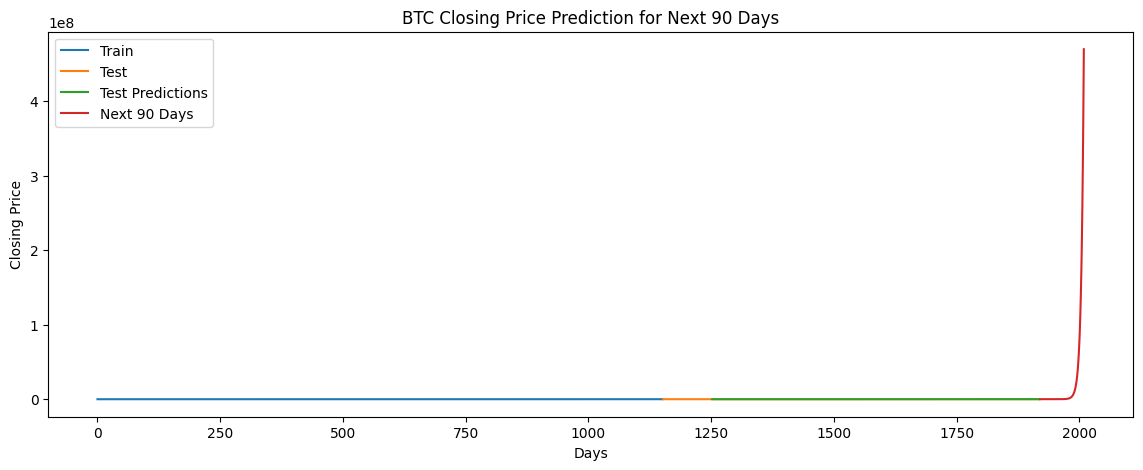

Predicted closing prices for the next 90 days:
[6.84880312e+04 6.91404766e+04 7.00525703e+04 7.05946719e+04
 7.09295703e+04 7.12043672e+04 7.14755156e+04 7.18008047e+04
 7.18156562e+04 7.29876875e+04 7.42808125e+04 7.49099141e+04
 7.47521797e+04 7.54421953e+04 7.59504688e+04 7.56209141e+04
 7.51550391e+04 7.46972109e+04 7.48092188e+04 7.53482031e+04
 7.70008750e+04 7.88135781e+04 8.01240781e+04 8.16965000e+04
 8.29794922e+04 8.39087266e+04 8.44371016e+04 8.50280859e+04
 8.56940391e+04 8.65699375e+04 8.76283203e+04 8.91902422e+04
 9.07711172e+04 9.24901719e+04 9.50598203e+04 9.85828438e+04
 1.02709461e+05 1.06774891e+05 1.10300594e+05 1.13641953e+05
 1.17513266e+05 1.21978977e+05 1.27411828e+05 1.34037094e+05
 1.42681203e+05 1.53971703e+05 1.67404391e+05 1.83779375e+05
 2.03920891e+05 2.28970016e+05 2.59922750e+05 2.97072094e+05
 3.43210844e+05 4.00720125e+05 4.72162844e+05 5.60629375e+05
 6.70208000e+05 8.06393562e+05 9.74528562e+05 1.18147862e+06
 1.43627088e+06 1.75003775e+06 2.13615

In [80]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BTC Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())